In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [5]:
test_batch_size = 1000
batch_size = 64
epochs = 2
lr = 0.1
gamma = 0.7
seed = 1
no_cuda = False
log_interval = 1000
save_model = True
use_cuda = True

In [6]:
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [8]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [9]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296684

Test set: Average loss: 0.0860, Accuracy: 9738/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.152109

Test set: Average loss: 0.0603, Accuracy: 9803/10000 (98%)



In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [11]:
print(example_targets.shape)
print(example_data.shape)

torch.Size([1000])
torch.Size([1000, 1, 28, 28])


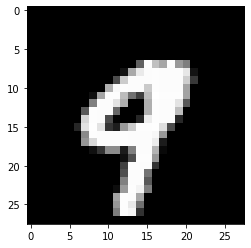

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')

In [13]:
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [14]:
x = example_data[0,:,:,:].unsqueeze_(0).requires_grad_(True)
print(x.shape)

y = example_targets[0]

torch.Size([1, 1, 28, 28])


In [15]:
y_hat = model(x.cuda() if torch.cuda.is_available() else x)
y_hat.shape

torch.Size([1, 10])

In [16]:
y_hat.argmax()

tensor(9)

### step by step derivatives

In [21]:
# df/dx
ddx, = torch.autograd.grad(model(x.cuda() if torch.cuda.is_available() else x).mean(), x, create_graph=True)

In [22]:
ddx.shape

torch.Size([1, 1, 28, 28])

In [48]:
ddx

tensor([[[[-3.2770e-05, -5.5677e-04, -2.5757e-03, -2.9031e-03, -6.0298e-03,
           -3.8940e-03, -6.2280e-03, -3.9427e-03, -5.0610e-03, -2.8879e-03,
           -1.9421e-03, -1.1954e-03, -4.8955e-03, -1.9348e-03, -6.2777e-03,
           -6.3607e-03, -6.6682e-03, -1.4676e-03, -3.4618e-03, -3.2806e-03,
           -2.6692e-03, -3.6411e-03, -1.7690e-03, -2.5446e-03, -3.9587e-03,
           -1.2988e-03, -1.2671e-03,  0.0000e+00],
          [-1.2607e-03, -1.4836e-03, -7.7014e-03, -1.0101e-02, -1.1406e-02,
           -1.0520e-02, -5.6209e-03, -8.2497e-03, -8.7602e-03, -9.8769e-03,
           -5.5021e-03, -5.4520e-03, -1.4540e-03, -3.9205e-03, -5.4357e-03,
           -5.8760e-03, -4.5047e-03, -6.0691e-03, -8.2106e-03, -6.9847e-03,
           -9.1863e-03, -9.6529e-03, -1.1756e-02, -7.3019e-03, -5.2228e-03,
           -4.1374e-03,  6.4060e-04,  0.0000e+00],
          [-9.6830e-03, -1.4974e-02, -2.9527e-02, -2.7405e-02, -3.4065e-02,
           -2.6722e-02, -2.8105e-02, -2.5517e-02, -3.7201e-02,

In [23]:
ddx.mean().backward()
# x.grad = d^2 f(x)/dx^2

In [24]:
#d^2 f(x)/dx^2
x.grad

tensor([[[[-1.7243e-07, -1.4995e-07, -5.2889e-07, -4.9517e-07, -5.1664e-07,
           -1.8443e-07, -4.5787e-07, -2.5424e-07, -3.2324e-07, -2.3714e-07,
           -1.1731e-07, -1.7984e-07, -7.0563e-07, -2.4730e-07, -7.9666e-07,
           -6.3901e-07, -7.2562e-07, -3.0222e-07, -6.5007e-07, -5.5131e-07,
           -8.2631e-07, -7.3763e-07, -5.9509e-07, -5.0188e-07, -6.4047e-07,
           -1.6384e-07, -1.5262e-07,  0.0000e+00],
          [-5.0514e-07, -3.8173e-07, -8.6231e-07, -1.2627e-06, -9.2583e-07,
           -1.2396e-06, -7.7866e-07, -7.8729e-07, -1.0781e-06, -1.1675e-06,
           -1.3668e-06, -1.0399e-06, -9.5799e-07, -7.6683e-07, -1.1108e-06,
           -8.6956e-07, -7.1934e-07, -1.2678e-06, -1.2778e-06, -1.2590e-06,
           -1.6380e-06, -1.5076e-06, -1.5186e-06, -9.3186e-07, -7.1954e-07,
           -6.8662e-07, -3.4591e-08,  0.0000e+00],
          [-1.3225e-06, -1.9444e-06, -3.7132e-06, -3.6717e-06, -4.4529e-06,
           -4.5441e-06, -4.8661e-06, -4.4905e-06, -5.8888e-06,

In [25]:
### taylor series
str("P(x) = f(a) + (df(a)/dx)(x-a)/1! + (d^2f(a)/dx^2)(x-a)^2/2! + ...")

'P(x) = f(a) + (df(a)/dx)(x-a)/1! + (d^2f(a)/dx^2)(x-a)^2/2! + ...'

In [26]:
y_hat.shape

torch.Size([1, 10])

In [27]:
# f'(x)
ddx.shape

torch.Size([1, 1, 28, 28])

In [28]:
# f''(x)
x.grad.shape

torch.Size([1, 1, 28, 28])

In [29]:
terms = ddx*x + x.grad*(x.pow(2))

In [30]:
terms.shape

torch.Size([1, 1, 28, 28])

In [31]:
class DynamicGNoise(nn.Module):
    def __init__(self, shape, std=0.05):
        super().__init__()
        self.noise = torch.zeros(shape).requires_grad_(True)
        self.std   = std
        
    def forward(self, x):
#         if not self.training: return x
        self.noise.data.normal_(0, std=self.std)
        
        print(x.size(), self.noise.size())
        return x + self.noise

In [32]:
noise = DynamicGNoise((1,1,28,28)).to(device)

In [33]:
x_new = noise(x)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


In [34]:
x_new.shape

torch.Size([1, 1, 28, 28])

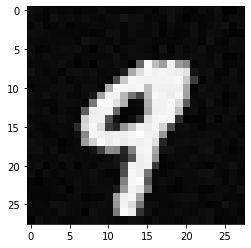

In [35]:
plt.imshow(x_new.squeeze(0).squeeze(0).detach().numpy(), cmap='gray', interpolation='none')

In [36]:
f = model(x_new.cuda() if torch.cuda.is_available() else x_new)

In [37]:
term = ddx*(x_new-x) + x.grad*((x_new-x)**2)

In [38]:
term.shape

torch.Size([1, 1, 28, 28])

In [39]:
term_ = model(term.cuda() if torch.cuda.is_available() else term)

In [40]:
new_f = f + term_

#### Verified that image around '9' can be labels by this formula

In [41]:
new_f.argmax()

tensor(9)

### conversion of the above steps in functions

In [50]:
def jacobian(y, x, create_graph=False):                                                               
    jac = []                                                                                          
    flat_y = y.reshape(-1)                                                                            
    grad_y = torch.zeros_like(flat_y)                                                                 
    for i in range(len(flat_y)):                                                                      
        grad_y[i] = 1.                                                                                
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)                                                
                                                                                                      

In [56]:
def hessian(y, x):                                                                                    
    return jacobian(jacobian(y, x, create_graph=True), x)                                                                                                                                                 

In [43]:
##Testing purpose
# def f(x):                                                                                             
#     return x * x * torch.arange(4, dtype=torch.float)                                                                                                                                         

In [44]:
# # x = torch.ones(4, requires_grad=True)                                                                 
# print(jacobian(y_hat, x.cuda() if torch.cuda.is_available() else x))                                                                              
# print(hessian(y_hat, x.cuda() if torch.cuda.is_available() else x))                                                                               

In [52]:
# first order derivative term
jacobian_ = jacobian(y_hat, x.cuda() if torch.cuda.is_available() else x)
jacobian_

tensor([[[[[[-7.9347e-05, -1.7507e-03, -3.1055e-03,  ..., -4.3161e-04,
             -1.0861e-03,  0.0000e+00],
            [-6.0485e-04, -3.3902e-04, -9.2835e-03,  ..., -3.1430e-03,
              1.6033e-03,  0.0000e+00],
            [-1.1189e-02, -1.6605e-02, -2.8805e-02,  ..., -1.9936e-02,
             -5.6186e-03,  0.0000e+00],
            ...,
            [-3.9298e-03, -1.0150e-02, -2.3722e-02,  ..., -6.4343e-03,
              1.8156e-04,  0.0000e+00],
            [-5.1156e-04, -5.0992e-03, -2.4434e-03,  ..., -2.7301e-03,
              2.4985e-03,  0.0000e+00],
            [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
              0.0000e+00,  0.0000e+00]]]],



         [[[[ 1.9134e-04,  4.8019e-04, -1.9804e-03,  ..., -3.5184e-03,
             -2.1848e-03,  0.0000e+00],
            [-2.8843e-03, -3.2973e-03, -1.2641e-02,  ..., -7.1284e-03,
              2.3629e-03,  0.0000e+00],
            [-1.6594e-02, -1.7972e-02, -4.2712e-02,  ..., -1.0207e-02,
             -3.24

In [54]:
jacobian_.shape

torch.Size([1, 10, 1, 1, 28, 28])

In [57]:
# second order derivative term
hessian_ = hessian(y_hat, x.cuda() if torch.cuda.is_available() else x)
hessian_

tensor([[[[[[[[[[-2.9564e-08, -3.1707e-08, -8.4246e-08,  ...,
                 -2.0645e-08, -2.2228e-08,  0.0000e+00],
                [-7.7097e-08, -6.1862e-08, -1.2703e-07,  ...,
                 -7.5188e-08, -1.1989e-09,  0.0000e+00],
                [-1.6444e-07, -2.1252e-07, -4.1174e-07,  ...,
                 -1.7700e-07, -4.9974e-08,  0.0000e+00],
                ...,
                [-7.0926e-08, -1.5927e-07, -2.0928e-07,  ...,
                 -6.6091e-08,  6.1691e-08,  0.0000e+00],
                [-2.1255e-08, -4.3232e-08,  1.1287e-08,  ...,
                 -2.9079e-08,  3.8447e-08,  0.0000e+00],
                [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,
                  0.0000e+00,  0.0000e+00,  0.0000e+00]]]],



             [[[[-3.1707e-08, -3.9855e-08, -8.4422e-08,  ...,
                 -1.5120e-08, -2.0199e-08,  0.0000e+00],
                [-7.3703e-08, -6.3106e-08, -1.1697e-07,  ...,
                 -3.9974e-08,  3.4420e-09,  0.0000e+00],
                [-1.1

In [58]:
hessian_.shape

torch.Size([1, 10, 1, 1, 28, 28, 1, 1, 28, 28])

In [ ]:
# stack jacobians and add the resultant tensor to hessian
# then we take the mean on hessian to get its dimension to [1,10]
# we then add it to y_hat
# the resultant vector will give probability distribution for noisy '9' in our case.

# WIP